# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import time


import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
297941,2016-03-11 11:48:56,5990,small,2009,manual,68,other,30000,9,petrol,toyota,no,2016-03-11 00:00:00,0,26127,2016-03-12 15:46:08
288769,2016-03-31 23:56:19,10000,sedan,2006,auto,204,c_klasse,80000,9,petrol,mercedes_benz,no,2016-03-31 00:00:00,0,30163,2016-04-07 04:16:31
10588,2016-03-21 19:54:02,4500,sedan,2008,manual,105,bravo,150000,8,gasoline,fiat,no,2016-03-21 00:00:00,0,6766,2016-03-21 19:54:02
229337,2016-03-29 16:42:49,3700,small,2009,manual,77,punto,100000,8,petrol,fiat,no,2016-03-29 00:00:00,0,86807,2016-04-06 02:15:49
218211,2016-04-01 01:57:43,1654,small,2001,manual,90,almera,150000,3,petrol,nissan,NaN,2016-04-01 00:00:00,0,46509,2016-04-07 05:15:43


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates() # удалим дубликаты строк
df.duplicated().sum()

0

In [8]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,13718,NaN,NaN,17
mean,NaN,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,NaN,0.0,50508.503800,NaN
std,NaN,4514.176349,NaN,90.228466,NaN,189.851330,NaN,37905.083858,3.726432,NaN,NaN,NaN,NaN,0.0,25783.100078,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


### Вывод

1. Датасет содержит информацию  о 354369 автомобилях, 16 параметров для каждого авто.
2. В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired есть  пропущенные значения, которые необходимо обработать.
3. В столбце RegistrationYear есть аномальные значения, минимальный год выпуска 1000 год, а максимальный 9999. 
4. В столбце Price есть аномальное значение, минимальная стоимость авто равна 0.
5. В столбце Power  максимальное значение  мощности аномально велико.

#### Изменим названия столбцов, переведем в  змеиный регистр.

In [9]:
df.columns = df.columns.str.replace('(?!^)([A-Z])', r'_\1').str.lower()
df.sample(5)


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
145913,2016-03-28 17:56:09,300,wagon,1997,auto,0,v40,150000,0,NaN,volvo,yes,2016-03-28 00:00:00,0,17111,2016-04-06 23:46:09
229847,2016-03-18 23:52:17,2999,small,2007,manual,68,clio,150000,7,gasoline,renault,no,2016-03-18 00:00:00,0,49716,2016-04-04 01:45:05
350332,2016-03-23 18:56:21,1350,bus,2006,manual,90,other,150000,6,gasoline,citroen,yes,2016-03-23 00:00:00,0,83676,2016-03-23 18:56:21
250918,2016-03-28 18:44:03,3500,wagon,2006,manual,75,kangoo,80000,5,petrol,renault,no,2016-03-28 00:00:00,0,13359,2016-04-01 03:44:25
119099,2016-03-24 18:51:41,5900,convertible,1997,auto,193,slk,150000,5,lpg,mercedes_benz,no,2016-03-24 00:00:00,0,30982,2016-04-07 13:15:48


#### Посмотрим когда была создана последняя анкета.  

In [10]:
df.sort_values(by='date_created', ascending=False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
335002,2016-04-07 10:36:17,1500,sedan,1995,auto,101,a4,100000,9,petrol,audi,no,2016-04-07 00:00:00,0,73463,2016-04-07 10:36:17
124667,2016-04-07 03:36:36,15990,suv,2006,auto,232,q7,150000,6,gasoline,audi,yes,2016-04-07 00:00:00,0,82008,2016-04-07 03:36:36
38676,2016-04-07 11:25:37,0,NaN,1970,NaN,0,NaN,100000,0,NaN,volkswagen,NaN,2016-04-07 00:00:00,0,35753,2016-04-07 12:06:18
214934,2016-04-07 00:36:35,13899,suv,2010,auto,218,x_reihe,150000,2,gasoline,bmw,no,2016-04-07 00:00:00,0,65479,2016-04-07 07:25:17
316998,2016-04-07 12:36:21,16950,sedan,2012,manual,143,1er,80000,10,gasoline,bmw,no,2016-04-07 00:00:00,0,92421,2016-04-07 12:36:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175103,2016-03-08 17:57:45,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10 00:00:00,0,26382,2016-04-05 20:46:54
86601,2016-04-02 19:47:40,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07 00:00:00,0,76228,2016-04-07 09:15:23
342275,2016-03-05 21:44:26,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18 00:00:00,0,76275,2016-04-05 17:46:09
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20 00:00:00,0,24558,2016-04-07 03:45:01


#### Удалим столбцы не представляющие интереса для дальнейшего исследования.

In [11]:
df = df.drop(['date_crawled','registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
df.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
132840,5000,convertible,2002,auto,163,slk,150000,petrol,mercedes_benz,no
338608,650,small,1996,manual,60,corsa,150000,petrol,opel,yes
126991,6700,small,2011,manual,69,ibiza,70000,petrol,seat,no
182240,4700,sedan,2010,manual,95,colt,90000,petrol,mitsubishi,no
155875,990,sedan,1995,manual,116,6_reihe,150000,petrol,mazda,no


#### Обработаем пропуски в данных. Заполним пропуски  значением "unknown".

In [12]:
df.vehicle_type.value_counts() # уникальные значения, проверка на релевантность данных 

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [13]:
df.vehicle_type.fillna('unknown', inplace=True)
df.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [14]:
df.gearbox.value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [15]:
df.gearbox.fillna('unknown', inplace=True)
df.gearbox.value_counts()

manual     268249
auto        66283
unknown     19833
Name: gearbox, dtype: int64

In [16]:
df.fuel_type.value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [17]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol') # переименуем gasoline в petrol, т.к. это одно и тоже топливо, 
                                                                 # разные названия для Европы и США
df.fuel_type.fillna('unknown', inplace=True)
df.fuel_type.value_counts()

petrol      315068
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [18]:
df.repaired.value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

In [19]:
df.model.value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [20]:
df[['model', 'repaired']] = df[['model', 'repaired']].fillna('unknown')
df.model.value_counts()

golf                  29232
other                 24420
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

#### Проверим наличие пропусков.

In [21]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

#### Изучим распределение цен на авто.

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64


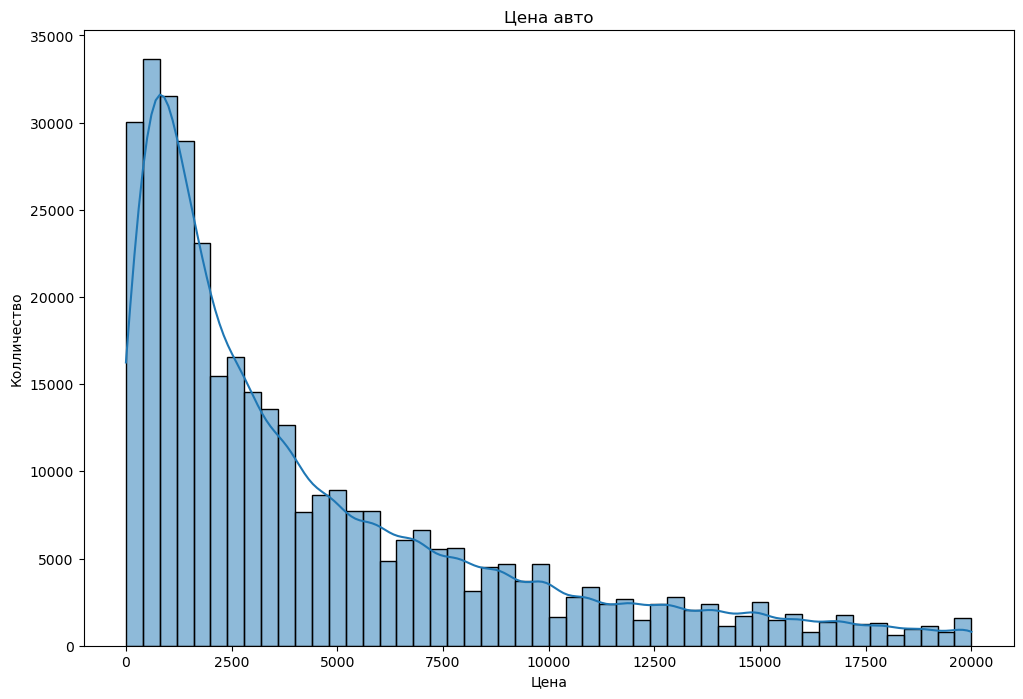

In [22]:
print(df.price.value_counts())

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='price', kde=True, bins=50)
plt.title('Цена авто')
plt.xlabel('Цена' )
plt.ylabel('Колличество')
plt.show()



#### Считаю , что стоимость авто менее 100 евро  - это аномальные значения. Удалим строки с  ценой менее 100 евро.


In [23]:
df = df.loc[df['price'] > 100]
print(df.sort_values(by='price'))

        price vehicle_type  registration_year  gearbox  power     model  \
221816    101        small               1999   manual     60     corsa   
154988    101      unknown               2016  unknown      0    escort   
332022    101        small               2015   manual     86   i_reihe   
90696     101        small               2015   manual     85   i_reihe   
25683     105        wagon               1994   manual     60      golf   
...       ...          ...                ...      ...    ...       ...   
310494  20000        sedan               2008     auto    286   x_reihe   
288348  20000        sedan               2013     auto    110      golf   
83020   20000        sedan               1950   manual      0   unknown   
285893  20000        sedan               2012  unknown    184       3er   
262000  20000        sedan               2011     auto    265  c_klasse   

        kilometer fuel_type           brand repaired  
221816     150000    petrol            opel 

#### Изучим распределение данных по году выпуска автомобилей.   Возможно, что на торговой площадке продаются  и ретро автомобили. Однако, такие  раритетные автомобили имеют принципиально  другое ценообразование, поэтому  удалим все строки с датой выпуска автомобилей ранее 1970 года и  годом выпуска позднее 2016 года (год  последней заполненной анкеты).

In [24]:
df.loc[(df['registration_year'] < 1970)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown
630,12000,sedan,1969,manual,140,s_klasse,80000,petrol,mercedes_benz,no
1794,12800,coupe,1965,manual,90,other,100000,petrol,ford,no
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no
2262,6500,convertible,1965,auto,360,unknown,150000,petrol,sonstige_autos,unknown
...,...,...,...,...,...,...,...,...,...,...
353447,2900,small,1969,manual,18,500,5000,petrol,fiat,no
353531,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,unknown
353961,200,unknown,1910,unknown,0,unknown,5000,petrol,sonstige_autos,unknown
354037,10500,convertible,1968,manual,54,other,20000,unknown,renault,no


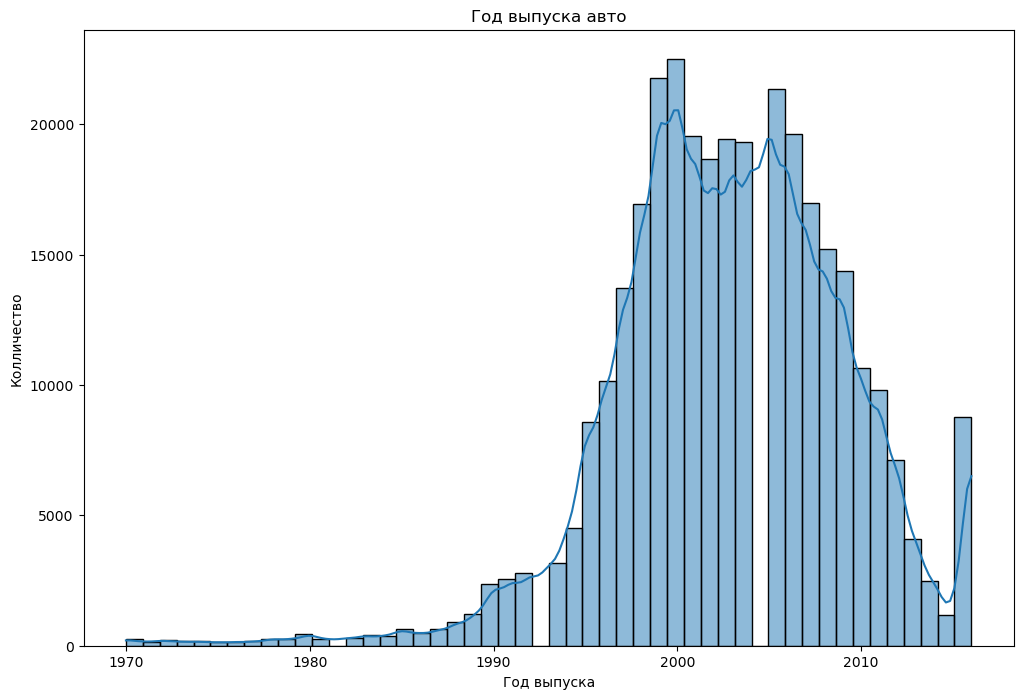

In [25]:
df = df.loc[(df['registration_year'] >= 1970) & (df['registration_year'] <= 2016)]
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='registration_year', kde=True, bins=50)
plt.title('Год выпуска авто')
plt.xlabel('Год выпуска' )
plt.ylabel('Колличество')
plt.show()

#### Изучим распределение данных по мощности автомобилей.   Автомобили с мощностью двигатеоя  более 600 л. сил - это суперкары. Суперкары  так же как и  ретро автомобили имеют   ценообразование отличное от  ценообразования серийных автомобилий. Поэтому  мы будем рассматривать автомобили с мощностью двигателя менее 600 л. сил. 

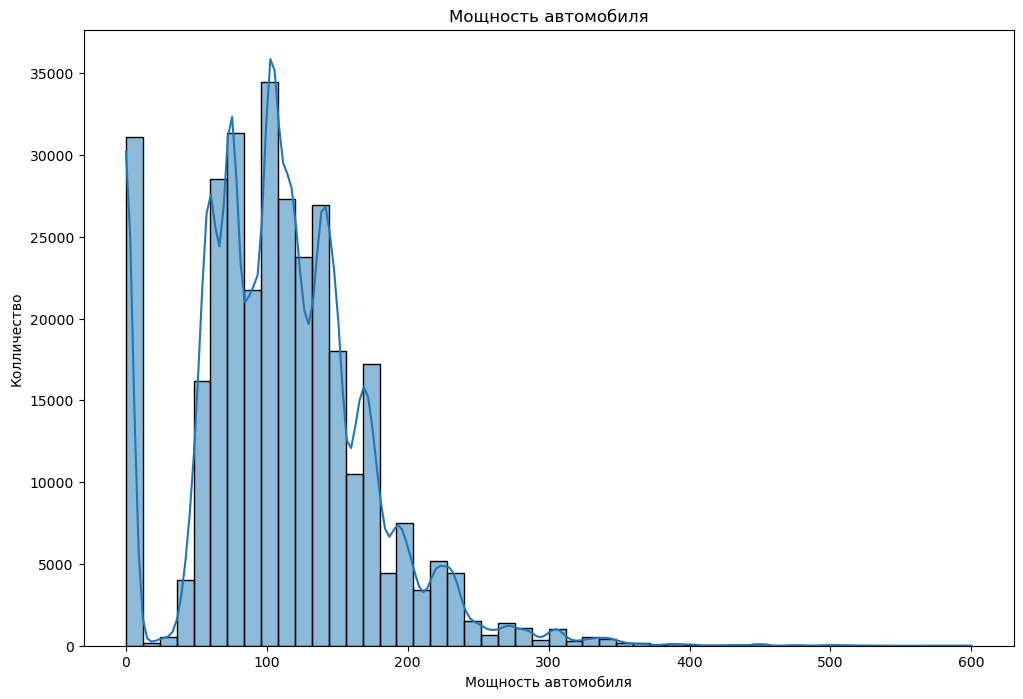

In [26]:
df = df.loc[df['power'] <= 600 ]
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='power', kde=True, bins=50)
plt.title('Мощность автомобиля')
plt.xlabel('Мощность автомобиля')
plt.ylabel('Колличество')
plt.show()

#### На графике присутсвует наличие выброса в районе 0. Возможно это автомобиль в разборе и не имеет двигателя на данный момент. Проверим наше предположение.

In [27]:
print('Количество автомобилей  с нулевой  мощностью', + len(df.loc[df['power'] == 0]))
print('Количество автомобилей  с нулевой  мощностью и побывавщих в ремонте', + len(df.loc[(df['power'] == 0) & (df['repaired'] == 'yes')]))

Количество автомобилей  с нулевой  мощностью 30851
Количество автомобилей  с нулевой  мощностью и побывавщих в ремонте 3676


In [28]:
#заполним  нулевые значения мощности  медианным значением по бренду авто
df['power'] = df.groupby('brand')['power'].transform(lambda x: x.replace(0, x.median()))

In [29]:
df.sample(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
161180,1750,small,2002,manual,58.0,twingo,150000,petrol,renault,no
84274,1100,unknown,1995,unknown,143.0,100,150000,unknown,audi,unknown
2143,5000,coupe,2000,auto,306.0,cl,150000,lpg,mercedes_benz,no
77996,600,sedan,1997,manual,73.0,3_reihe,150000,petrol,mazda,no
344700,4190,small,2012,manual,69.0,punto,100000,petrol,fiat,no


#### Очевидно, что наше предположение неверно. Т.к. мы рассматриваем  автомобили, выпущенные после 1970 года, то будем рассматривать авто с мощностью двигателя более 30 лош. сил. 

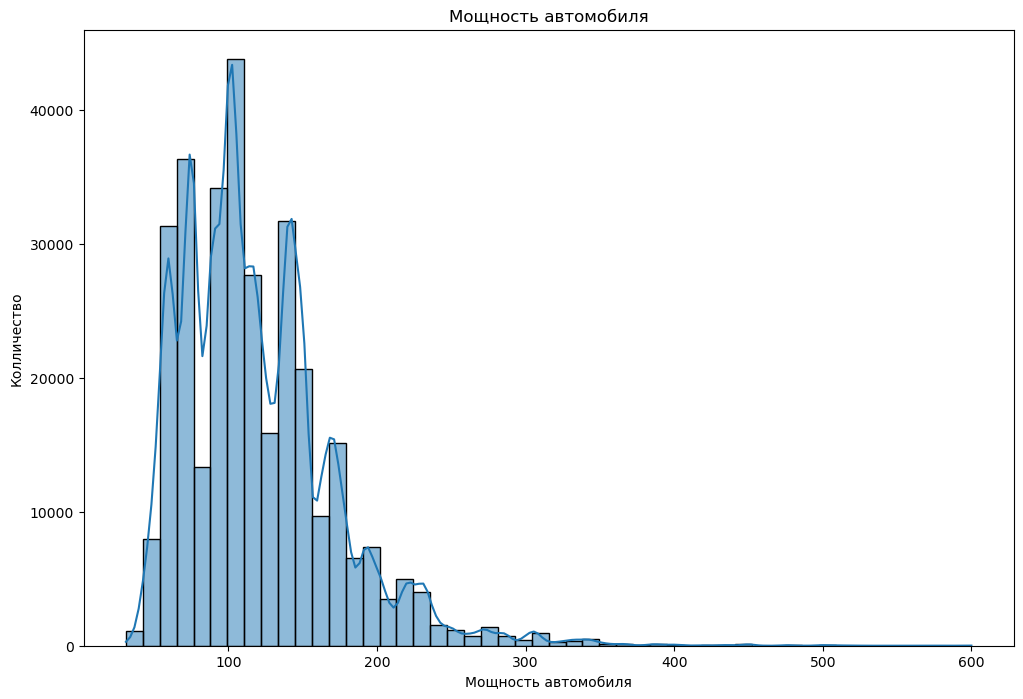

In [30]:
df = df.loc[df['power'] > 30 ]
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='power', kde=True, bins=50)
plt.title('Мощность автомобиля')
plt.xlabel('Мощность автомобиля')
plt.ylabel('Колличество')
plt.show()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324037 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              324037 non-null  int64  
 1   vehicle_type       324037 non-null  object 
 2   registration_year  324037 non-null  int64  
 3   gearbox            324037 non-null  object 
 4   power              324037 non-null  float64
 5   model              324037 non-null  object 
 6   kilometer          324037 non-null  int64  
 7   fuel_type          324037 non-null  object 
 8   brand              324037 non-null  object 
 9   repaired           324037 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.2+ MB


In [32]:
df.duplicated().sum()


43084

In [33]:
df = df.drop_duplicates().reset_index(drop=True)
print(df.duplicated().sum())
df.sample(5)

0


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
210854,4450,wagon,2003,manual,116.0,avensis,150000,petrol,toyota,no
65606,2450,unknown,2016,manual,90.0,golf,150000,petrol,volkswagen,no
156564,999,bus,1999,manual,101.0,zafira,150000,petrol,opel,unknown
146812,700,sedan,1990,manual,110.0,3er,150000,petrol,bmw,yes
158387,480,small,1992,manual,90.0,corsa,125000,petrol,opel,unknown


### Мы произвели предобработку данных

1. Перевели названия столбцов в змеиный регистр.
2. Удалили столбцы не представляющие интереса для исследования.
3. Заполнили  пропуски в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired.
4. Избавилисть от аномальных значений в столбцах RegistrationYear, Price, Power. 
5. Удалили дубликаты.

## Обучение моделей

#### Разделим данные на обучающую и тестовую выборки. 

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['price'], axis=1), df['price'], test_size=0.25, random_state=12345)
print(features_train.shape)
print(features_test.shape)
display(features_train.head(1))
display(features_test.head(1))


(210714, 9)
(70239, 9)


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
193038,small,2002,manual,60.0,punto,150000,petrol,fiat,no


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
160561,unknown,1995,unknown,180.0,golf,150000,unknown,volkswagen,unknown


#### Преобразуем  категориальные признаки  в численные с помощью OneHotEncoder. Это необходимо для  линейных моделей.

In [35]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()
target_train_ohe = target_train.copy()
target_test_ohe = target_test.copy()

#категориальные признаки для OHE 
ohe_features = features_train_ohe.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[ohe_features])
# добавляем закодированные признаки
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[ohe_features])
# удаляем изначальные  колонки
features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[ohe_features])
features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)

display(features_train_ohe.head(1))
display(features_test_ohe.head(1))


,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
193038,2002,60.0,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
160561,1995,180.0,150000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Произведем масштабирование  признаков для выборок.

In [36]:
numeric = list(features_train_ohe)
scaler = StandardScaler(with_std=False) 
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric]) # стандартизация  обучающей выборки 
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) # стандартизация тестовой  выборки

display(features_train_ohe.head(1))
display(features_test_ohe.head(1))

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
193038,-0.855273,-60.407669,22402.094783,-0.062967,-0.049593,-0.009914,-0.267505,0.771425,-0.037159,-0.061002,...,-0.016212,-0.006701,-0.00242,-0.006972,-0.014299,-0.000076,-0.204305,-0.009572,-0.185151,-0.104502


,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
160561,-7.855273,59.592331,22402.094783,-0.062967,-0.049593,-0.009914,-0.267505,-0.228575,-0.037159,0.938998,...,-0.016212,-0.006701,-0.00242,-0.006972,-0.014299,-0.000076,0.795695,-0.009572,0.814849,-0.104502


In [37]:
display(features_test.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
160561,unknown,1995,unknown,180.0,golf,150000,unknown,volkswagen,unknown
149554,convertible,2005,manual,109.0,2_reihe,90000,petrol,peugeot,unknown
6192,small,2009,auto,120.0,cooper,50000,petrol,mini,no
237229,small,2003,manual,75.0,polo,125000,petrol,volkswagen,no
34301,small,2007,manual,60.0,corsa,150000,petrol,opel,no


#### Перекодируем категориальные признаки используя порядковое кодирование (OrdinalEncoder).

In [38]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train[['vehicle_type', 'gearbox', 'model', 'fuel_type',
            'brand', 'repaired']] = enc.fit_transform(features_train[['vehicle_type', 'gearbox', 'model', 'fuel_type',
            'brand', 'repaired']])
features_test[['vehicle_type', 'gearbox', 'model', 'fuel_type',
            'brand', 'repaired']] = enc.transform(features_test[['vehicle_type', 'gearbox', 'model', 'fuel_type',
            'brand', 'repaired']])
display(features_train.head(1))
display(features_test.head(1))

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
193038,5.0,2002,1.0,60.0,176.0,150000,5.0,9.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
160561,7.0,1995,2.0,180.0,116.0,150000,6.0,38.0,1.0


#### Произведем масштабирование числовых  признаков для выборок.

In [39]:
numeric = ['power', 'kilometer']
scaler = StandardScaler() 
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric]) # стандартизация  обучающей выборки 
features_test[numeric] = scaler.transform(features_test[numeric]) # стандартизация тестовой  выборки
display(features_train.head(1))
display(features_test.head(1))

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
193038,5.0,2002,1.0,-1.160833,176.0,0.595715,5.0,9.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
160561,7.0,1995,2.0,1.145165,116.0,0.595715,6.0,38.0,1.0


#### Модель линейной регрессии

In [40]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [41]:
%%time
model = LinearRegression()
#model.fit(features_train_ohe, target_train_ohe)
#predictions_train_ohe = model.predict(features_train_ohe)
#RMSE = mean_squared_error(target_train_ohe, predictions_train_ohe)**0.5
#print(RMSE)
#scores = cross_val_score(model, features_train_ohe, target_train_ohe,
                         #scoring = mean_squared_error(features_train_ohe, target_train_ohe)**0.5, cv=5)

scores = cross_val_score(model, features_train_ohe, target_train_ohe, scoring = RMSE_score, cv=5,verbose=3)
print(scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................ score: (test=-2634.300) total time=   2.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................ score: (test=-2618.371) total time=   2.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV] END ............................ score: (test=-2640.196) total time=   2.1s
[CV] END ............................ score: (test=-2610.560) total time=   2.1s
[CV] END ............................ score: (test=-2630.515) total time=   2.0s
[-2634.30025906 -2618.37141514 -2640.19587735 -2610.56006028
 -2630.515161  ]
Wall time: 11.3 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.2s finished


#### Используем GridSearchCV для подбора параметров  моделей RandomForest, DecisionTree и LightGBM.

#### Модель решающего дерева.

In [42]:
%%time
model_DT = DecisionTreeRegressor(random_state=12345)
param_DT = {'max_depth':range (1,10)}
grid_DT = GridSearchCV(model_DT, param_DT, scoring = RMSE_score)
grid_DT.fit(features_train,target_train)

print(grid_DT.best_params_)
print(grid_DT.best_score_)


{'max_depth': 9}
-2067.490037279084
Wall time: 6.82 s


#### Модель случайного леса.

In [43]:
%%time
model_RF = RandomForestRegressor(random_state=12345)
param_RF = {'n_estimators':[100, 200],
             'max_depth':range (3, 20, 3)}
grid_RF = GridSearchCV(model_RF, param_RF, scoring = RMSE_score, verbose=3)
grid_RF.fit(features_train,target_train)

print(grid_RF.best_params_)
print(grid_RF.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .max_depth=3, n_estimators=100;, score=-2965.252 total time=   5.9s
[CV 2/5] END .max_depth=3, n_estimators=100;, score=-2948.605 total time=   6.0s
[CV 3/5] END .max_depth=3, n_estimators=100;, score=-2934.907 total time=   5.9s
[CV 4/5] END .max_depth=3, n_estimators=100;, score=-2919.759 total time=   5.8s
[CV 5/5] END .max_depth=3, n_estimators=100;, score=-2952.778 total time=   6.1s
[CV 1/5] END .max_depth=3, n_estimators=200;, score=-2965.320 total time=  11.7s
[CV 2/5] END .max_depth=3, n_estimators=200;, score=-2944.631 total time=  11.7s
[CV 3/5] END .max_depth=3, n_estimators=200;, score=-2933.561 total time=  11.8s
[CV 4/5] END .max_depth=3, n_estimators=200;, score=-2918.928 total time=  11.7s
[CV 5/5] END .max_depth=3, n_estimators=200;, score=-2951.167 total time=  11.8s
[CV 1/5] END .max_depth=6, n_estimators=100;, score=-2293.690 total time=  10.9s
[CV 2/5] END .max_depth=6, n_estimators=100;, sc

#### Модель LightGBM.

In [44]:
categorical_columns = ['vehicle_type','registration_year', 'gearbox', 'model', 'fuel_type',
                       'brand', 'repaired']
features_train[categorical_columns] = features_train[categorical_columns].astype('category')
features_test[categorical_columns] = features_test[categorical_columns].astype('category')
features_train.info()
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210714 entries, 193038 to 217570
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       210714 non-null  category
 1   registration_year  210714 non-null  category
 2   gearbox            210714 non-null  category
 3   power              210714 non-null  float64 
 4   model              210714 non-null  category
 5   kilometer          210714 non-null  float64 
 6   fuel_type          210714 non-null  category
 7   brand              210714 non-null  category
 8   repaired           210714 non-null  category
dtypes: category(7), float64(2)
memory usage: 6.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70239 entries, 160561 to 28944
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       70239 non-null  category
 1   registration_year

In [45]:
%%time
model_lgbm = LGBMRegressor(random_state=12345)
param_lgbm = {
    'n_estimators': [100, 200, 500],
    'max_depth': [15,30],
    'num_leaves': [20, 50, 100]
}
grid_lgbm = GridSearchCV(model_lgbm, param_lgbm, scoring = RMSE_score, verbose=3)
grid_lgbm.fit(features_train,target_train)

print(grid_lgbm .best_params_)
print(grid_lgbm .best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=15, n_estimators=100, num_leaves=20;, score=-1688.640 total time=   0.3s
[CV 2/5] END max_depth=15, n_estimators=100, num_leaves=20;, score=-1661.142 total time=   0.3s
[CV 3/5] END max_depth=15, n_estimators=100, num_leaves=20;, score=-1685.766 total time=   0.3s
[CV 4/5] END max_depth=15, n_estimators=100, num_leaves=20;, score=-1670.692 total time=   0.3s
[CV 5/5] END max_depth=15, n_estimators=100, num_leaves=20;, score=-1669.250 total time=   0.3s
[CV 1/5] END max_depth=15, n_estimators=100, num_leaves=50;, score=-1645.323 total time=   0.4s
[CV 2/5] END max_depth=15, n_estimators=100, num_leaves=50;, score=-1620.071 total time=   0.5s
[CV 3/5] END max_depth=15, n_estimators=100, num_leaves=50;, score=-1641.040 total time=   0.4s
[CV 4/5] END max_depth=15, n_estimators=100, num_leaves=50;, score=-1623.561 total time=   0.4s
[CV 5/5] END max_depth=15, n_estimators=100, num_leaves=50;, score=-1626.18

### Мы построили модели и подобрали гиперпараметры. Посчитали показатель RMSE  для моделей на тестовой выборке. Оценили время  необходимое на подбор гиперпараметров.  

1. Налучшие показатели RMSE у моделей  LightGBM и модели случайного леса
2. Максимальное время подбора гиперпараметроа у модели случайного леса

## Анализ моделей

#### Создадим функцию  для вычисления времени обучения и предсказания для моделей  с подобранными выше гиперпараметрами. А так же значение  RMSE на тестовой выборке. 

In [49]:
def calc_time(model, features_train, target_train):
    start_time = time.time()
    model.fit(features_train, target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    predict = model.predict(features_train)
    second_time = time.time() - start_time
    return first_time, second_time

#### Применим нашу функции к различным моделям. 

In [50]:
model_LR = calc_time(LinearRegression(), features_train_ohe, target_train_ohe)

In [52]:
model_LR

(3.406480312347412, 0.056847572326660156)

In [53]:
model_DT = calc_time(DecisionTreeRegressor(random_state=12345,
                                           max_depth=9), features_train, target_train)

In [54]:
model_DT

(0.3042275905609131, 0.03191423416137695)

In [56]:
model_RF =calc_time(RandomForestRegressor(random_state=12345, n_estimators=200,
                          max_depth = 18), features_train, target_train)

In [57]:
model_RF

(67.06345582008362, 7.630826711654663)

In [59]:
model_lgbm =calc_time(LGBMRegressor(random_state=12345, n_estimators=500, num_leaves = 100,
                          max_depth = 30), features_train, target_train)

In [60]:
model_lgbm 

(2.1946699619293213, 1.4950413703918457)

#### Финальные результаты.

In [61]:
table = pd.DataFrame([[model_DT[0], model_DT[1],(-1)*scores.mean()], [model_DT[0], model_DT[1], (-1)*grid_DT.best_score_], [model_RF[0], model_RF[1], (-1)*grid_RF.best_score_],
                      [model_lgbm[0], model_lgbm[1], (-1)* grid_lgbm .best_score_]], 
             columns=['Время обучения', 'Время предсказания', 'RMSE'], 
                      index=['LR','DecisionTrees', 'RandomForest','LGBM' ])
display(table)

,Время обучения,Время предсказания,RMSE
LR,0.304228,0.031914,2626.788555
DecisionTrees,0.304228,0.031914,2067.490037
RandomForest,67.063456,7.630827,1685.497929
LGBM,2.194670,1.495041,1592.274845


### Исходя из итоговой таблицы  можно сделать вывод:

1. Самое высокое качество предсказания у модели LGBM.
2. Модель RandomForest	так же имеет хороший показтель RMSE, однако модель имеет самое большое время обучения и предсказания.
3. Модель линейной регрессии  и DecisionTrees имеют неплохие скорости обучения и предсказаний, но показатель RMSE значиельно выше, чем у модели LGBM.	


### Наилучшая модель для заказчика это LGBM.

In [62]:
predict = grid_lgbm.predict(features_test)
print('RMSE модели LGBM на  тестовой выборке', RMSE(target_test, predict))

RMSE модели LGBM на  тестовой выборке 1592.6043373056293
